In [2]:
import numpy as np
from scipy import stats


In [77]:
def load_peaks(file_path):
    """
    Loads the second column (peak positions) from a TSV file into a NumPy array.

    Parameters:
        file_path (str): Path to the TSV file.

    Returns:
        np.ndarray: Array of peak positions.
    """
    return np.loadtxt(file_path, delimiter="\t", usecols=1)

def split_into_bins(peaks, bin_size=25000, genome_length=None):
    """
    Splits the peak positions into bins of the specified size using vectorized operations.
    Ensures that empty bins are represented as arrays containing NaN.

    Parameters:
        peaks (np.ndarray): Array of peak positions.
        bin_size (int): The size of each bin in base pairs.
        genome_length (int): The length of the genome in base pairs. If None, inferred from peaks.

    Returns:
        list of np.ndarray: List of arrays, each containing peaks in one bin or NaN for empty bins.
    """
    # Determine the total number of bins
    if genome_length is None:
        genome_length = peaks.max() + bin_size  # Extend to cover the last peak
    num_bins = int((genome_length + bin_size - 1) // bin_size)  # Ceiling division

    # Calculate the bin indices for each peak
    bin_indices = np.floor_divide(peaks, bin_size)

    # Create a list to hold peaks for each bin
    binned_peaks = [np.array([np.nan]) for _ in range(num_bins)]  # Default to NaN for empty bins

    # Assign peaks to the appropriate bins
    for bin_idx in np.unique(bin_indices):
        binned_peaks[int(bin_idx)] = peaks[bin_indices == bin_idx]

    return binned_peaks

def calculate_distance(peaks1, peaks2):
    """
    Calculates the total distance between peaks1 and their nearest peaks in peaks2.

    Parameters:
        peaks1 (np.ndarray): Array of peak positions for sample 1.
        peaks2 (np.ndarray): Array of peak positions for sample 2.

    Returns:
        float: Total distance or NaN if any input is empty.
    """
    if np.isnan(peaks1).all() or np.isnan(peaks2).all():
        return np.nan  # Return NaN if either bin is empty

    distances = []
    for peak1 in peaks1:
        nearest_distance = np.min(np.abs(peak1 - peaks2))
        distances.append(nearest_distance)

    return np.median(distances)

def process_peaks(file1, file2):
    """
    Processes the TSV files from two directories, calculates the summed absolute distances between
    corresponding peaks in 25,000 bp bins, and stores the results in a numpy array.

    Parameters:
        directory1 (str): Path to the directory containing the original peak files.
        directory2 (str): Path to the directory containing the reconstructed peak files.

    Returns:
        np.ndarray: Array containing the summed distances for each bin.
    """
    summed_distances = []
    if True:

            peaks1 = load_peaks(file1)
            peaks2 = load_peaks(file2)

            # Split the peaks into bins
            bins1 = split_into_bins(peaks1)
            bins2 = split_into_bins(peaks2)

            for bin_peaks1, bin_peaks2 in zip(bins1, bins2):
                distance = calculate_distance(bin_peaks1, bin_peaks2)
                summed_distances.append(distance)

    return np.array(summed_distances)


In [31]:
def remove_nan_pairs(array1, array2):
    """
    Removes elements from both arrays where either array contains NaN.

    Parameters:
        array1 (np.ndarray): The first array.
        array2 (np.ndarray): The second array.

    Returns:
        tuple: Two arrays with NaN-containing elements removed.
    """
    if array1.shape != array2.shape:
        raise ValueError("Both arrays must have the same shape.")
    
    # Create a mask for non-NaN values in both arrays
#     valid_mask = ~np.isnan(array1) & ~np.isnan(array2)
    valid_mask = ~np.isnan(array1) * ~np.isnan(array2)

    
    # Apply the mask to both arrays
    return array1[valid_mask], array2[valid_mask]


In [78]:
real_BH01 = '/cluster/work/medinfmk/cfDNA-Snyder/results/Maria/testing_model/third_try/real/MaxFinder_output_truth.tsv'
predicted_BH01 = '/cluster/work/medinfmk/cfDNA-Snyder/results/Maria/testing_model/third_try/reconstructed/MaxFinder_output_predictions.tsv'
reconstructed = process_peaks(predicted_BH01, real_BH01)

In [79]:
downsampled_BH01 = '/cluster/work/medinfmk/cfDNA-Snyder/results/Maria/testing_model/third_try/downsampled/MaxFinder_output_downsampled.tsv'
downsampled = process_peaks(downsampled_BH01, real_BH01)

In [80]:
downsampled_filtered, reconstructed_filtered = remove_nan_pairs(downsampled,reconstructed)

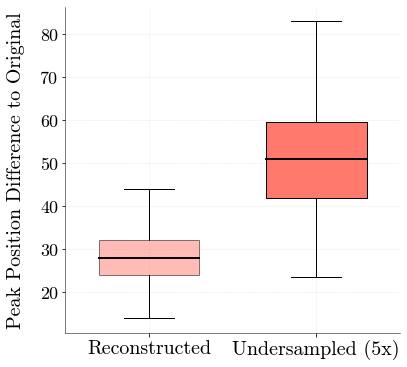

In [102]:
import matplotlib.pyplot as plt
from matplotlib import font_manager

# Load the custom font (Computer Modern Roman)
font_path = '/cluster/work/medinfmk/cfDNA-Snyder/results/Maria/cmr10.ttf'  # Replace with the correct path to the font file
prop = font_manager.FontProperties(fname=font_path)

# Update the font settings to use the custom font
plt.rcParams.update({
    "text.usetex": False,  # Disable LaTeX rendering
    "font.family": prop.get_name(),  # Use the custom font
    "axes.unicode_minus": True,  # Handle minus sign properly
})
# Creating a box plot with color and median customizations
undersampled_data = [downsampled_filtered]  # Undersampled data
reconstructed_data = [reconstructed_filtered]  # Reconstructed data
data = reconstructed_data+undersampled_data 

plt.figure(figsize=(6, 6))

bp = plt.boxplot(data, patch_artist=True, widths=0.6, positions=[1, 2], labels=[ 'Reconstructed','Undersampled (5x)'],showfliers=False)

# Set colors for the boxes
box_colors = ['#ff796c','#ff796c']  # Red for undersampled, green for reconstructed
alpha_values = [0.5,1.0]

for patch, color, alpha in zip(bp['boxes'], box_colors, alpha_values):
    patch.set_facecolor(color)
    patch.set_alpha(alpha)

# Define median properties
median_color = 'black'
median_linewidth = 2  # Set the desired width of the median line
for median in bp['medians']:
    median.set(color=median_color, linewidth=median_linewidth)

# plt.xlabel('Data Type', fontsize=15)
plt.ylabel('Peak Position Difference to Original', fontsize=20, labelpad = 15)
# plt.ylim(-2000, 30000)
# plt.axhline(y=6500, color='blue', linestyle='--', linewidth=1, label='Random')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.2)

ax = plt.gca()  # Get current axis

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['left'].set_linewidth(0.5)  # Customize the left spine
ax.spines['bottom'].set_linewidth(0.5)  # Customize the bottom spine
plt.xticks( fontsize=20)
plt.yticks(fontsize=18)
# Display the plot with medians
plt.savefig('/cluster/work/medinfmk/cfDNA-Snyder/results/Maria/figures/boxplots_undersampledVSreconstructed.svg', format='svg')
plt.show()


In [90]:
stat, p_value = stats.wilcoxon(reconstructed_filtered, downsampled_filtered)

# Display results
print(f"Statistic: {stat}")
print(f"P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("The distributions of the two paired samples are significantly different.")
else:
    print("No significant difference was found between the two paired samples.")

Statistic: 1178.0
P-value: 8.786575668864966e-58
The distributions of the two paired samples are significantly different.
